# <center> Lecture12 : Poisson & Negative Binomial Regression </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## Intro  

* 在之前的课程中，我们探索了自我控制的影响因素，我们将自我控制分数作为连续变量来处理  

* 在真实的数据处理中，因变量的类型并不仅限于连续数据(continuous data)，可能我们关心被试是否做出正确回答(binary data)，或是给出正确回答的个数(count data)  

* 目前，我们只介绍了正态回归模型，但它并非适用于所有数据类型  

* 在本节课中，我们关注如何对**计数数据**进行分析  


**数据集介绍**  

* 使用的数据集仍然来自来自Human Penguin Project (Hu et al., 2018, doi: 10.17605/OSF.IO/H52D3)，本节课中我们关注**压力**和**是否恋爱**对**社交网络大小**的影响。  

* 在这份数据中，社交网络大小的定义为，在每两周内，个体的社交对象数量(社交对象包含父母、子女、同事等等)  


> * 数据来源: Hu, C.-P. et al. (2018). Raw data from the Human Penguin Project. Open Science Framework. https://doi.org/10.17605/OSF.IO/H52D3  
> * 压力量表来源：Cohen, S., Kamarck, T. & Mermelstein, R. A global measure of perceived stress. J. Health. Soc. Behav. 24, 385–396 (1983).  
> * 社交网络测量：Cohen, S. et al. Social ties and susceptibility to the common cold. JAMA 277, 1940–1944 (1997).

**🤔研究问题：如何通过模型形式化这些问题？**  

**问题0:  哪种分布可以更好的描述社交网络变量（本节课主要内容）**   

问题1：个体压力与社交网络大小的关系

> * 个体在面对压力时，通常会寻求他人的支持和安慰，以缓解压力的影响。因此，压力可能会扩大个体社交网络  
> * 然而，个体在压力大时也可能会选择封闭自己，减小自己的社交网络，这也被认为是抑郁症产生的原因。  

问题2：恋爱情况与社交网络大小的关系  

> * 恋爱关系可能使个体与伴侣的社交圈子相互连接，进一步扩大其社交网络。  
> * 相反，恋爱双方可能缩小自己的社交网络，以此避免影响彼此关系的风险因素出现。  

**问题3：个体压力和恋爱情况与社交网络大小的关系（本节课主要内容）**

问题4：个体压力和恋爱情况对社交网络大小的交互作用  


**原始数据可视化**  

* 社交网络大小的分布情况  

* 压力与社交网络大小的散点图情况  

![Image Name](https://cdn.kesci.com/upload/s4o8026lgp.png?imageView2/0/w/960/h/960)

In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')

df = df_raw[df_raw["Site"] == "Tsinghua"]

#1 = "yes"; 2 = "no"
df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)
df["romantic_recode"] =  np.where(df['romantic'] == 1, "yes", "no")

#设置索引
df["index"] = range(len(df))
df = df.set_index("index")

**Normal regression model**  

首先，我们使用上节课学习过的正态回归模型来进行建模分析。  
* **然而，考虑到因变量为计数变量，并且在之前的可视化过程中发现，它的分布形式不符合正态分布。**  
* 因此，我们会在之后使用不同的分布来进行建模分析，并通过模型比较来说明哪种模型更适合现在的数据。  

$$  
 
\begin{array}{lcrl}  

\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} \\  
\text{priors:} & & \beta_{0}  & \sim N\left(20, 10^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 10^2 \right) \\  
                    & & \beta_2  & \sim N\left(0, 10^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.6)  .\\  
\end{array}  

$$  

* 我们快速运行模型定义、MCMC采样和后验预测分布的结果

In [3]:
with pm.Model(coords = {"obs_id": df.index}) as normal_model:

    beta_0 = pm.Normal("beta_0", mu=20, sigma=10)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)           #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)           #定义beta_2
    sigma = pm.Exponential("sigma", 0.6)                   #定义sigma

    stress = pm.MutableData("stress",df.stress, dims="obs_id")                           #自变量1:压力水平
    romantic = pm.MutableData("romantic",df.romantic, dims="obs_id")                              #自变量2:性别
    mu = pm.Deterministic("mu", beta_0 + beta_1*stress + beta_2*romantic, dims="obs_id")    #定义mu，自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.networksize, dims="obs_id") 

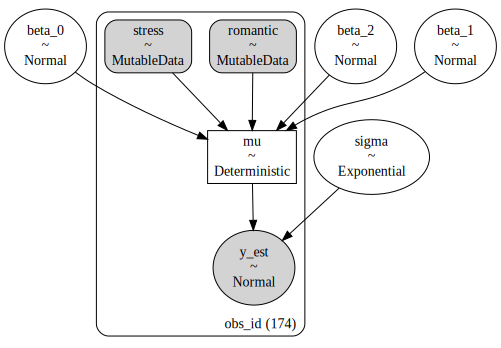

In [4]:
# 可视化模型（贝叶斯变量因果图）。 
# 我们使用 pymc 自带的 `model_to_graphviz` 方法来可视化模型中各变量的因果关系。
pm.model_to_graphviz(normal_model)

In [5]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with normal_model:
    # MCMC 近似后验分布
    normal_model_trace = pm.sample(
        draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
        tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
        chains=4,                     # 链数
        discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
        random_seed=84735)
    
    # 后验预测
    normal_model_ppc = pm.sample_posterior_predictive(normal_model_trace, random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 178 seconds.
Sampling: [y_est]


In [6]:
# 定义计算 MAE 函数
from statistics import median
def MAE(model_ppc):
    # 计算每个X取值下对应的后验预测模型的均值
    pre_y = model_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
    pre_y_mean = pre_y.mean(axis=1).values

    # 提取观测值Y，提取对应Y值下的后验预测模型的均值
    MAE = pd.DataFrame({
        "networksize_ppc_mean": pre_y_mean,
        "networksize_original": df.networksize
    })

    # 计算预测误差
    MAE["pre_error"] = abs(MAE["networksize_original"] -\
                            MAE["networksize_ppc_mean"])

    # 最后，计算预测误差的中位数
    MAE = median(MAE.pre_error)
    return MAE

In [7]:
# 定义计算超出HDI的数量
def counter_outlier(model_ppc, hdi_prob=0.95):
    # 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
    hdi = az.summary(model_ppc, kind="stats", hdi_prob=hdi_prob)
    lower = hdi.iloc[:,2].values
    upper = hdi.iloc[:,3].values

    # 将原数据中的自我控制分数合并，便于后续进行判断
    y_obs = model_ppc.observed_data["y_est"].values

    # 判断原数据中的压力分数是否在后验预测的95%可信区间内，并计数
    hdi["verify"] = (y_obs <= lower) | (y_obs >= upper)
    hdi["y_obs"] = y_obs
    hdi_num = sum(hdi["verify"])

    return hdi_num

In [8]:
normal_model_MAE = MAE(normal_model_ppc)
print(f"正态回归模型MAE: {normal_model_MAE:.2f}")

normal_model_outliers = counter_outlier(normal_model_ppc)
print(f"泊松回归模型超出95%hdi: {normal_model_outliers:.2f}")

正态回归模型MAE: 5.86
泊松回归模型超出95%hdi: 8.00


**PPC验证分析**  

从下面的结果可以发现，后验预测的分布为正态分布，然而它并不能准确捕获数据分布的特征。

<Axes: xlabel='y_est / y_est'>

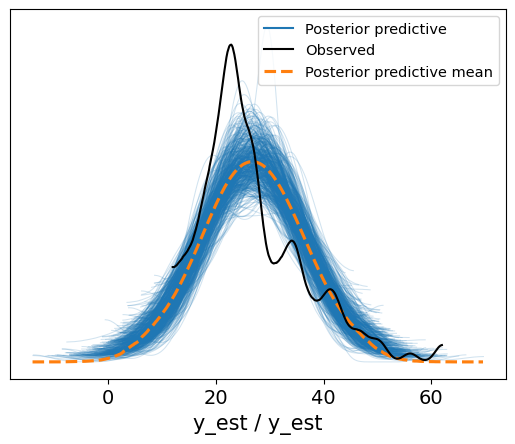

In [9]:
az.plot_ppc(normal_model_ppc, num_pp_samples=500)

## Poisson regression  

> 在lec5中，我们曾介绍过泊松分布，当时使用的例子为在亚运会时，中国每天获得的金牌数量。  

* **泊松分布(Poisson distribution)** 表示在给定$\lambda$下，用来描述时间在一定的时间或空间内发生的事件个数，$\lambda$为事件的平均发生率或事件发生的均值  

![Image Name](https://cdn.kesci.com/upload/s4o80dsjlv.png?imageView2/0/w/960/h/960)  



* 在正态回归模型中，对数据的假设为 $Y_i|\beta_0,\beta_1,\beta_2,\sigma  \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2}$  

    > 即因变量的均值可以表示为自变量的线性组合，且因变量符合以该均值为中心的正态分布 <br>  
    > 其中 X1 为压力，X2 为恋爱情况(1代表恋爱，0代表没有恋爱)  


* 类似的，我们也可以在泊松回归模型中做出这样的假设：  
$Y_i | \lambda_i \stackrel{ind}{\sim} Pois\left(\lambda_i \right) \;\; \text{ with } \;\; \lambda_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2}$  

**需要注意的是，在公式(1)中，事件发生数量或事件发生率 $\lambda_i$ 的范围为 0~∞之间，然而 $\beta_0 + \beta_1X_{i1} + \beta_2X_{i2}$ 的预测值会出现负数，这显然是不合理的**。

### 泊松回归模型公式  

为了解决这个问题，我们可以对 $\lambda_i$ 进行对数转换  

* 我们假设 $\lambda_i$ 的范围为 0~50。  
* 经过对数转化，$\text{log}(\lambda_i)$(纵坐标)的范围变为 -4~4。

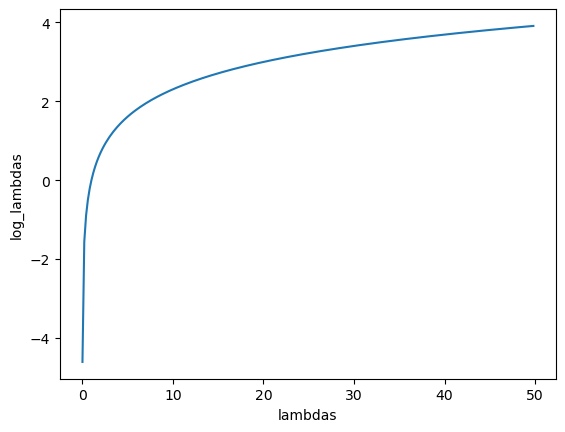

In [10]:
# 生成 lambdas 的范围为 0到50
lambdas = np.arange(0.01,50,0.2)
# 进行对数转换
log_lambdas = np.log(lambdas)

plt.plot(lambdas, log_lambdas)
plt.xlabel("lambdas")
plt.ylabel("log_lambdas")
plt.show()

* 此时，$log(\lambda_i)$既可以是正数也可以是负数  
$$  
Y_i | \beta_0,\beta_1, \beta_2 \stackrel{ind}{\sim} Pois\left(\lambda_i \right)  
\;\;\; \text{ with } \;\;\;  
\log\left( \lambda_i \right) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}.  
$$  

* 因此，泊松回归模型可以写成：  
$$  
Y_i | \beta_0,\beta_1, \beta_2 \stackrel{ind}{\sim} Pois\left(\lambda_i\right) \;\; \text{ with } \;\; \lambda_i = e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}}  
$$  

> 📍数学基础提醒：  
> $$  
> \begin{equation}  
> \begin{split}  
> \log(\lambda) & = \beta_0 + \beta_1 X_1 + \cdots \beta_p X_p \\  
> \lambda & = e^{\beta_0 + \beta_1 X_1 + \cdots \beta_p X_p}. \\  
> \end{split}  
> \end{equation}  
> $$  


在这里我们演示，在给定的$x$下 $\lambda_i = e^{\beta_0 + \beta_1 X_{i1}}$ 和 $\lambda_i = \beta_0 + \beta_1 X_{i1}$ 的差异  
- 其中，我们假设 x 的范围为 0~20，并且 $beta_0=0$, $beta_1=0.2$。  
- 使用 `np.exp` 可以进行逆对数转换。  
- 可以发现，逆对数转换的预测结果是**非线性**的。

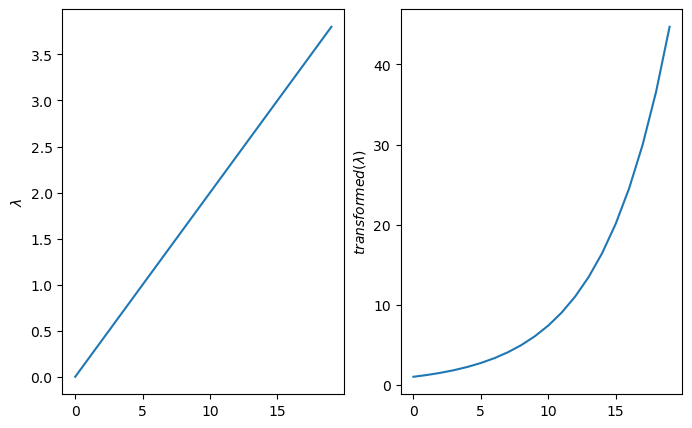

In [11]:
x = np.arange(20)
beta0 = 0
beta1 = 0.2
lambda1 = beta0 + beta1*x
lambda2 = np.exp(beta0 + beta1*x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5))

ax1.plot(x, lambda1)
ax1.set_ylabel("$\lambda$")
ax2.plot(x, lambda2)
ax2.set_ylabel("$transformed(\lambda)$")

plt.show()

### 公式中各参数的意义  

$$  
Y_i | \beta_0,\beta_1, \beta_2 \stackrel{ind}{\sim} Pois\left(\lambda_i\right) \;\; \text{ with } \;\; \lambda_i = e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}}  
$$  

* $\beta_0$  

    * 当$X_1= X_2 = 0$时，$\lambda_i = e^{\beta_0}$，当自变量都为0时，事件的平均发生率为 $e^{\beta_0}$  

* $\beta_1, ..., \beta_p$  

    * 假设 $X_2= 0$，$X_1= 1$ 时有 $\lambda_1 =e^{\beta_0 + \beta_1}$，$X_1= 2$ 时有 $\lambda_2 =e^{\beta_0 + 2\beta_1}$  

    * 此时有 $\frac{\lambda_2}{\lambda_1} = e^{\beta_1}$ ， 因此可以得到 $\beta_1 = log(\lambda_2) - log(\lambda_1)$ 或者 $e^{\beta_1} = \frac{\lambda_{x+1}}{\lambda_x}$  
    
    > 这表明：在其他自变量不变的情况下，自变量$X_1$每增加一个单位，事件的平均发生率$\lambda_i$就会以$e^{\beta_1}$倍增长  


### 泊松回归的预设(assumption)  

1. **计数数据：** 适用于因变量是计数数据的情况，即非负整数，例如事件发生的次数、计数的数量等。  

2. **独立性：** 假设每个观测值$Y_i$是相互独立的，即一个观测值不受其他观测值的影响。  

4. **线性关系：** 经对数转换后的因变量 可以写作自变量的线性组合，如：$\log\left( \lambda_i \right) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}+ \beta_3 X_{i3}$  

3. **均值等于方差：** 对于泊松分布$Pois(\lambda_i)$来说，其均值和方差都与事件的发生率相等(或约等)，$E(Y) = \text{Var}(Y) = \lambda$。  

    * 需要注意的是，这并不意味着因变量本身的分布是泊松分布。在泊松回归中，我们说的是，在给定的X下，其观测到的Y需要满足泊松分布  

    * 若此假设被满足，在数据中我们可以看到，因变量均值增大的同时，其变异性也在增大  

    * 该假设是泊松回归的一个重要假设，当均值远大于方差时，泊松回归可能并不是最佳的模型选择，之后我们会介绍这种情况下更适合的模型选择。  
    
<table>  
	  <tr>  
			<td><img src="https://cdn.kesci.com/upload/s4nzvo4egp.png?imageView2/0/w/960/h/960" alt="" width="200" height="150"> </td>  
			<td><img src="https://www.bayesrulesbook.com/bookdown_files/figure-html/ch-12-pois-assumptions-1.png" alt="" width="400" height="200"> </td>  
   </tr>  
</table>  

### 模型定义  

**定义泊松回归模型的先验**  

> 注意：定义先验时需要额外考虑对数变化对先验范围的影响。  

$$  
\begin{equation}  
\begin{array}{lcrl}  
\text{data:} & \hspace{.025in} & Y_i|\beta_0,\beta_1,\beta_2 & \stackrel{ind}{\sim} Pois\left(\lambda_i \right) \;\; \text{ with } \;\;  
\lambda_i = e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}}\\  
\text{priors:} & & \beta_{0} & \sim N\left(0, 0.5^2 \right) \\  
&& \beta_1 & \sim N(0, 0.1^2) \\  
&& \beta_2 & \sim N(0, 0.5^2) \\  
\end{array}  
\end{equation}  
$$

In [12]:
with pm.Model(coords = {"obs_id": df.index})  as poisson_model:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.1)          #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5)          #定义beta_2

    #自变量1:压力水平
    stress = pm.MutableData("stress",df.stress, dims="obs_id")                        
    #自变量2:性别
    romantic = pm.MutableData("romantic",df.romantic, dims="obs_id")            
    # 预测 lambda，自变量与先验结合
    lam = pm.Deterministic(
        "lam", 
        ##------------------------------------------------
        #  注意，这里我们使用 pm.math.exp 对预测进行逆对数转换
        #------------------------------------------------
        pm.math.exp(beta_0 + beta_1*stress + beta_2*romantic), 
        dims="obs_id")

    likelihood = pm.Poisson("y_est", mu=lam, observed=df.networksize, dims="obs_id") 

#### 先验预测检验  

* 前面说到使用正态回归模型会导致事件的发生率$\lambda_i$为负数，我们可以使用`pm.sample_prior_predictive`进行先验预测检验，来查看生成的$\lambda_i$情况

In [13]:
# 对正态回归模型进行先验预测
normal_prior =pm.sample_prior_predictive(samples=50, 
                                          model=normal_model,
                                          var_names=["mu"],
                                          random_seed=84735)
# 对泊松回归模型进行先验预测
poisson_prior =pm.sample_prior_predictive(samples=50, 
                                          model=poisson_model,
                                          var_names=["lam"],
                                          random_seed=84735)

Sampling: [beta_0, beta_1, beta_2]
Sampling: [beta_0, beta_1, beta_2]


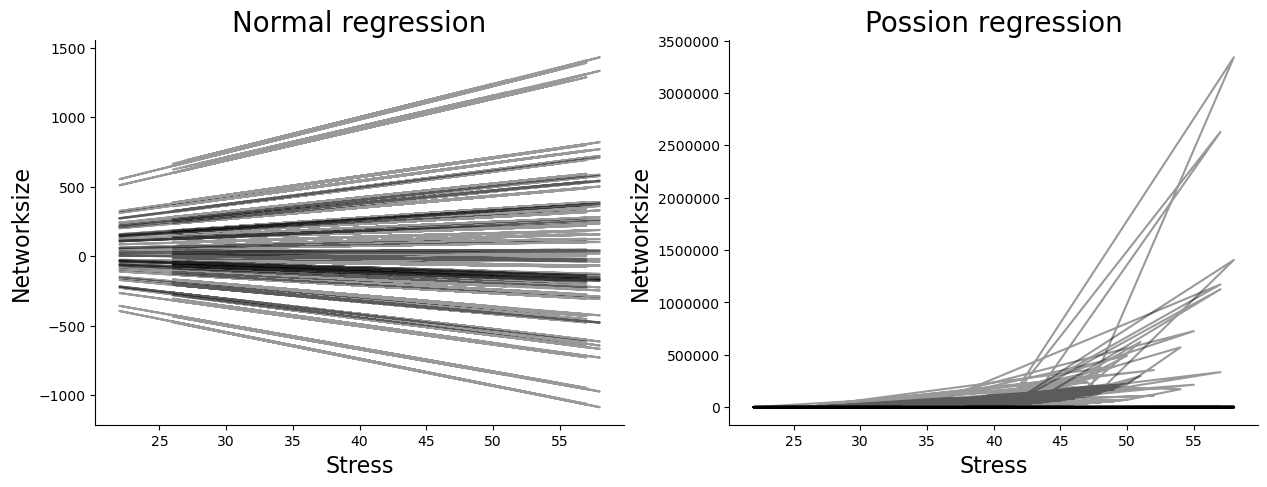

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))

#绘制正态回归模型中，预测变量为压力情况下的先验预测线性模型
ax[0].plot(normal_prior.constant_data["stress"], 
           normal_prior.prior["mu"].stack(sample=("chain", "draw")), c="k", alpha=0.4)

#设置坐标轴标题
ax[0].set_title('Normal regression', fontsize=20) 
ax[0].set_xlabel('Stress', fontsize=16) 
ax[0].set_ylabel('Networksize', fontsize=16) 

#绘制绘制泊松回归模型中，预测变量为压力情况下的先验预测线性模型
ax[1].plot(poisson_prior.constant_data["stress"], 
           poisson_prior.prior["lam"].stack(sample=("chain", "draw")), c="k", alpha=0.4)

#设置坐标轴标题、y轴刻度显示
ax[1].set_title('Possion regression', fontsize=20) 
ax[1].set_xlabel('Stress', fontsize=16) 
ax[1].set_ylabel('Networksize', fontsize=16) 
ax[1].ticklabel_format(axis='y', style='plain')

sns.despine()
plt.show()


#### 绘制模型图

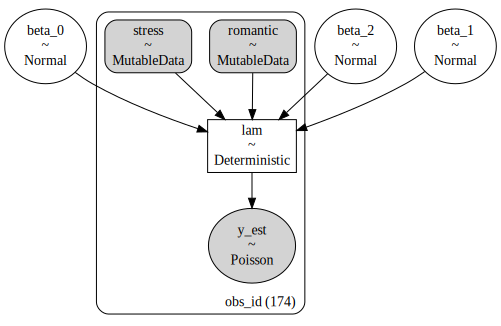

In [15]:
pm.model_to_graphviz(poisson_model)

### MCMC采样

In [16]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with poisson_model:
    poisson_model_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 153 seconds.


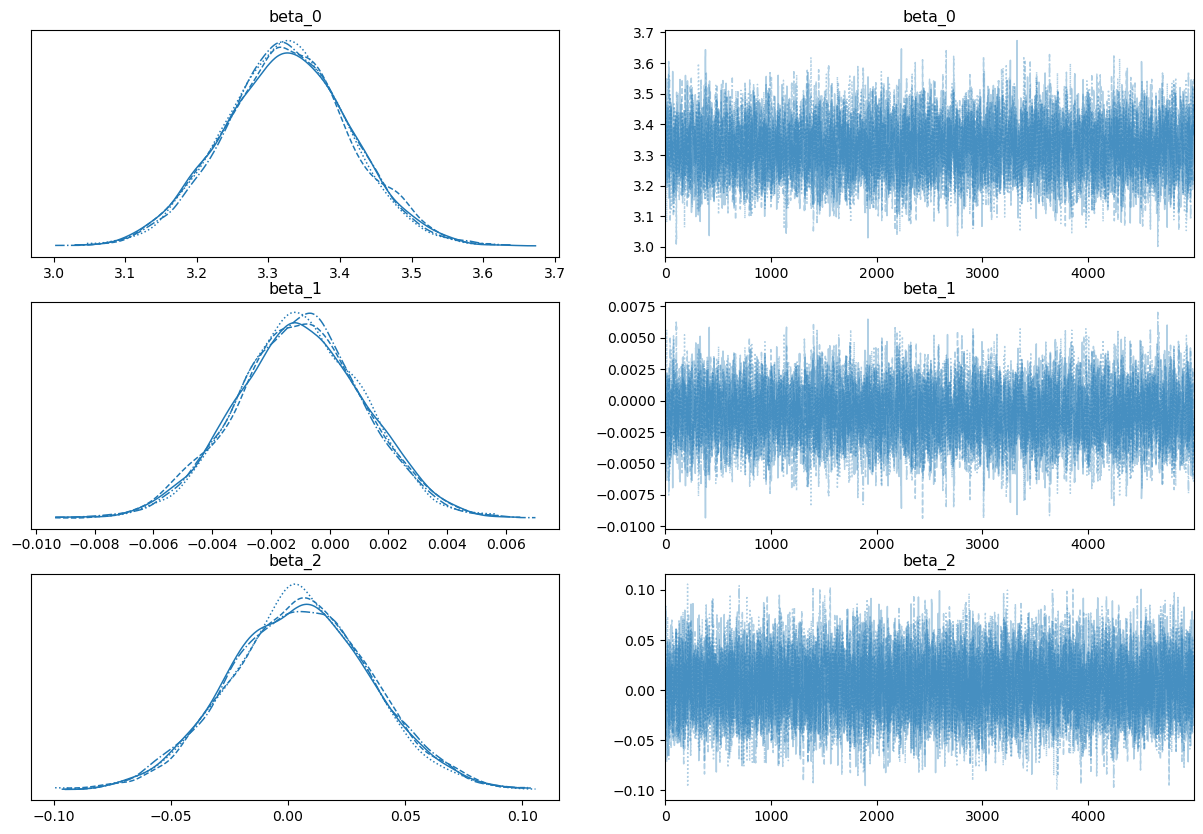

In [17]:
# 诊断后验分布估计情况
az.plot_trace(poisson_model_trace, var_names=["beta_0","beta_1","beta_2"],
              figsize=(15,10))
plt.show()

### 后验参数解释  

以下的结果显示：  
- $\beta_0 = 3.3$，那么 $e^{\beta_0} = 28$， 表明在 X1 和 X2 为 0时，个体社交网络大小为 27。  
- $\beta_1 = -0.001$， $e^{\beta_0} = 0.99$， 表明压力数值每增加1点，社交网络大小增加 0.99；$\beta_2 = 0.005$， $e^{\beta_2} = 1$，表明恋爱后社交网络大小增加 1。  
- 然而，$\beta_1$ 和 $\beta_2$ 的94%HDI均包括0，说明压力分数和恋爱情况不能有效预测社交网络的大小。  

我们接下来将通过后验预测来印证参数分析的结果。

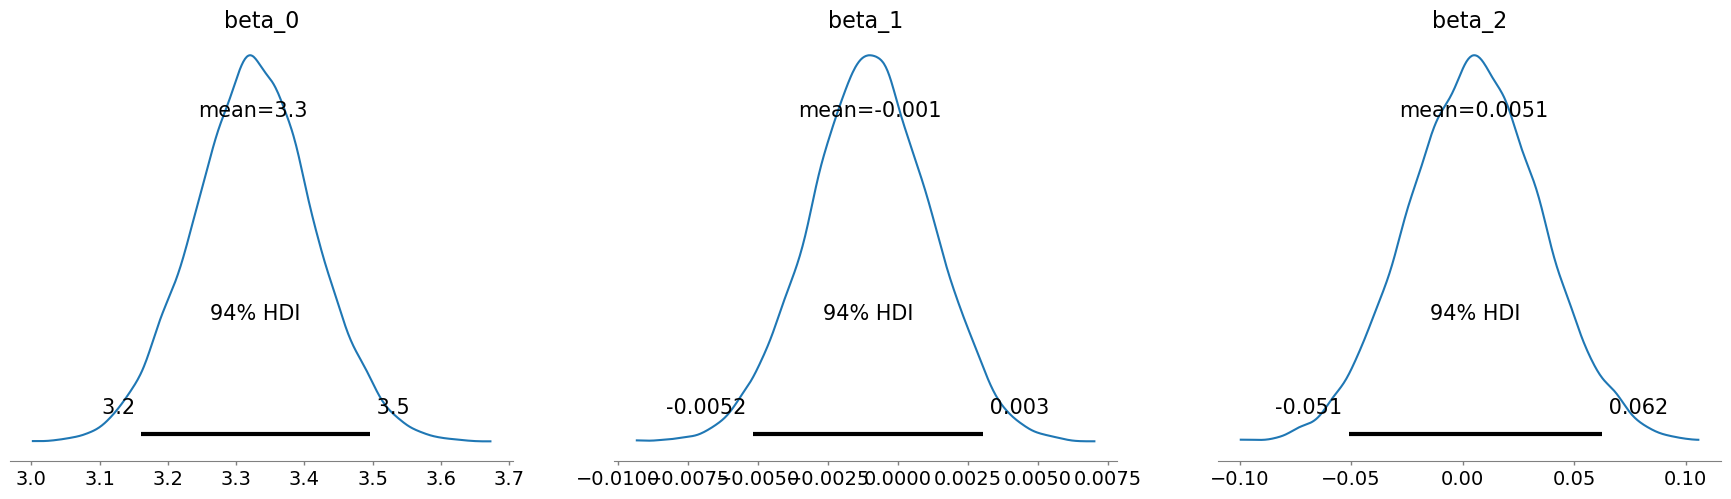

In [18]:
az.plot_posterior(poisson_model_trace, var_names=["beta_0","beta_1","beta_2"])
plt.show()

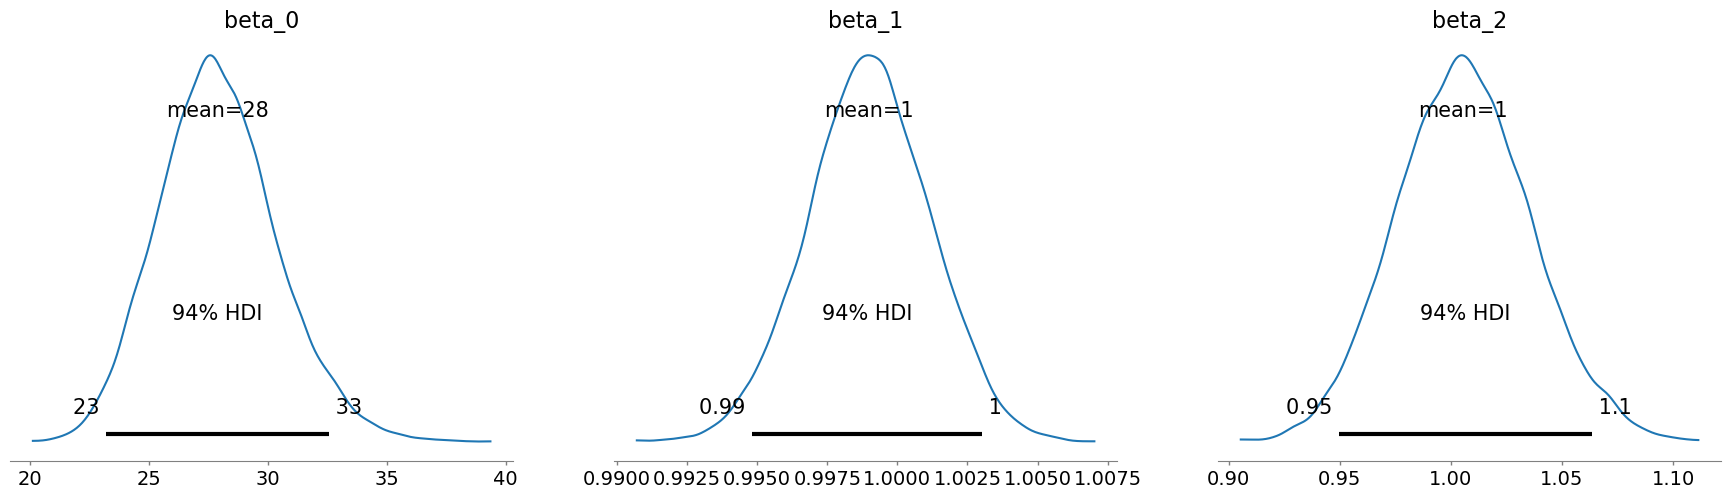

In [19]:
# 通过 np.exp 将 beta 参数进行转换
az.plot_posterior(poisson_model_trace, var_names=["beta_0","beta_1","beta_2"], transform = np.exp)
plt.show()

### 后验预测回归模型

In [20]:
with poisson_model:
    poisson_model_ppc = pm.sample_posterior_predictive(poisson_model_trace, random_seed=84735) 

Sampling: [y_est]


In [21]:
# 分别获取romantic=0及romantic=1时，压力变量对应的索引值
single_index = xr.DataArray(df.query("romantic == 0")["stress"])["index"].values
romantic_index = xr.DataArray(df.query("romantic == 1")["stress"])["index"].values

In [22]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
# 另一部分为不吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
single_para = poisson_model_trace.sel(obs_id=single_index)
romantic_para = poisson_model_trace.sel(obs_id=romantic_index)

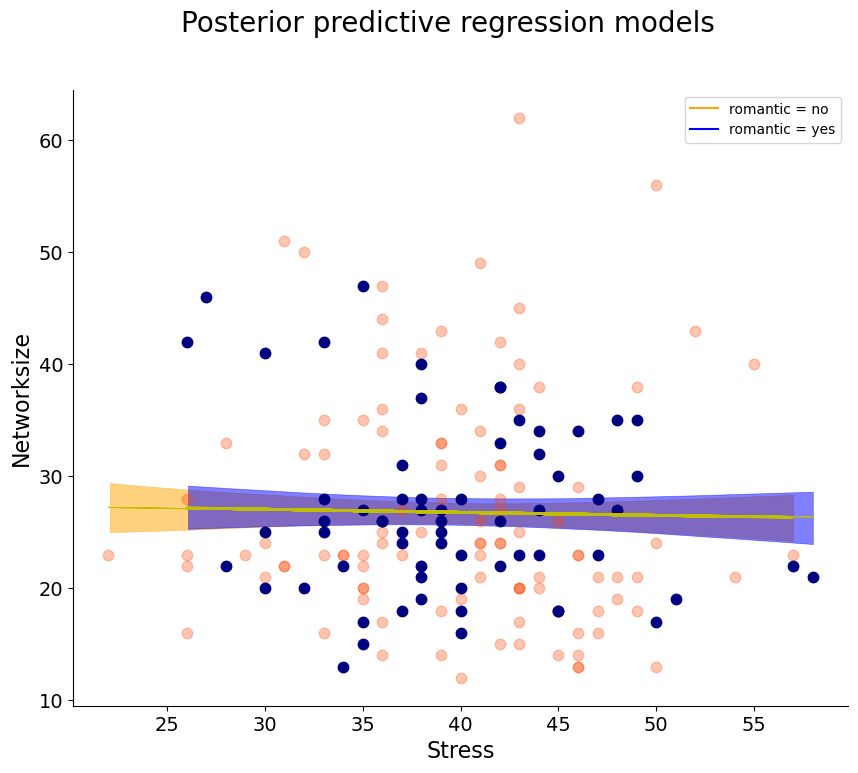

In [23]:
fig, axes = plt.subplots(figsize=(10, 8))

#绘制smoke=0情况下的后验预测线性模型
az.plot_lm(idata=single_para,
        y= "y_est",
        x= "stress",
        y_model = single_para.posterior["lam"],
        kind_model = "hdi",
        textsize=15,           
        grid=False,
        axes=axes,
        legend=False,
        y_model_fill_kwargs = {"color":"orange"},         # 设置 hdi 区间颜色
        y_kwargs =  {"color":"orangered","alpha":0.3}     # 设置观测值颜色
        )

#----------------------------------------#
#绘制smoke=1情况下的后验预测线性模型
az.plot_lm(idata=romantic_para,
        y= "y_est",
        x= "stress",
        y_model = romantic_para.posterior["lam"],
        kind_model = "hdi",
        textsize=15,
        grid=False,
        axes=axes,
        y_model_fill_kwargs = {"color":"blue"},         # 设置 hdi 区间颜色
        y_kwargs =  {"color":"navy"},                   # 设置观测值颜色
        legend=False)

#设置坐标轴标题
axes.set_xlabel('Stress', fontsize=16) 
axes.set_ylabel('Networksize', fontsize=16) 

#设置图例
handles = [
        plt.Line2D([], [], color="orange",
                    label = 'romantic = no'),
        plt.Line2D([], [], color="blue",
                    label = 'romantic = yes')]

axes.legend(handles=handles)
#----------------------------------------#
# 设置坐标轴字体大小、总标题
axes.tick_params(labelsize=14)  
fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

### 后验预测分布  

从后验预测的结果看，泊松回归模型比正态分布模型更接近观测数据的形态。

<Axes: xlabel='y_est / y_est'>

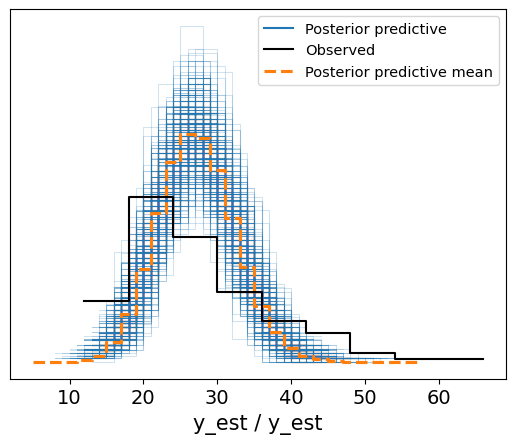

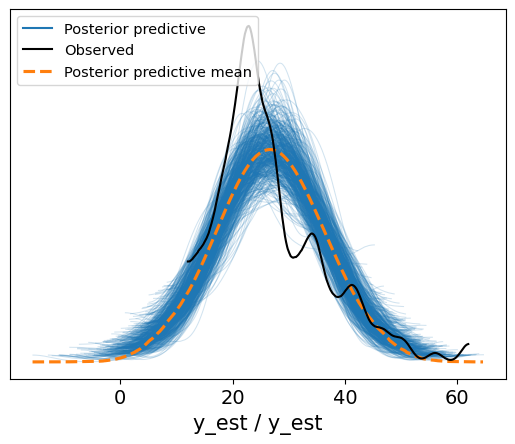

In [24]:
az.plot_ppc(poisson_model_ppc, num_pp_samples=500)
az.plot_ppc(normal_model_ppc, num_pp_samples=500)

### 评估后验预测

In [25]:
# 输出结果
poisson_model_MAE = MAE(poisson_model_ppc)
print(f"泊松回归模型MAE: {poisson_model_MAE:.2f}")

# 输出结果
poisson_model_outliers = counter_outlier(poisson_model_ppc)
print(f"泊松回归模型超出95%hdi: {poisson_model_outliers:.2f}")

泊松回归模型MAE: 5.91


泊松回归模型超出95%hdi: 46.00


### 模型比较

In [26]:
# 计算模型对数似然值以便进一步计算 ELPD. 
with normal_model:
    pm.compute_log_likelihood(normal_model_trace)

with poisson_model:
   pm.compute_log_likelihood(poisson_model_trace)

In [27]:
comparison_list = {
    "model1(normal)":normal_model_trace,
    "model2(poisson)":poisson_model_trace,
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1(normal),0,-637.875179,4.337762,0.000000,0.893892,11.968966,0.000000,False,log
model2(poisson),1,-709.111664,9.236234,71.236485,0.106108,30.371556,18.617575,False,log


🤔 **为什么泊松回归模型的表现反而变差了?**  

* 在泊松回归中，一个重要的假设是**均值与方差相等**，但实际上，我们的数据并不满足这个假设  

* 我们可以将根据恋爱状况和压力将数据进行分组，将每个组内的均值与方差进行比较  

![Image Name](https://cdn.kesci.com/upload/s4ok20dfbr.png?imageView2/0/w/960/h/960)

In [28]:
#此数据中，压力的范围为20-60，可以每隔5个取为一组，如20-25为第一组，25-30为第二组
stress_bins = range(20,60,5)

#设定分组名称
stress_labels = [f'[{i},{i+5}]' for i in stress_bins][:-1]

#使用pd.cut，根据压力分数生成新的一列，为压力组别
df["stress_group"] = pd.cut(df["stress"], 
                            bins=stress_bins, 
                            labels=stress_labels)

#根据恋爱情况、压力组对社交网络大小进行分组，并计算每个组内的均值与方差
df.groupby(['romantic_recode','stress_group'])['networksize'].agg(['mean','var'])
#(注：NaN是由于分组中缺乏数据)

mean         var
romantic_recode stress_group                       
no              [20,25]       23.000000         NaN
                [25,30]       23.750000   25.071429
                [30,35]       27.529412  106.264706
                [35,40]       28.370370   94.396011
                [40,45]       27.848485  114.507576
                [45,50]       22.631579  112.578947
                [50,55]       34.666667  142.333333
yes             [20,25]             NaN         NaN
                [25,30]       32.666667  133.466667
                [30,35]       25.636364  112.454545
                [35,40]       25.173913   32.422925
                [40,45]       28.357143   47.631868
                [45,50]       28.625000   40.267857
                [50,55]       19.000000         NaN

## Negative Binomial model  

> 我们可以看到总体来说组内的方差远大于均值，在这种情况下，我们认为因变量Y是过度分散(overdispersed)的。  

* 当因变量是计数数据，且过度分散，不符合泊松回归的预设时，我们可以:  

    (1) 选择非泊松回归模型  
    
    (2) 在泊松回归模型中增加一个过度分散参数(overdispersion parameter)  

* 此处我们介绍另一种非泊松回归模型，使用**负二项回归模型**来对因变量进行分析

### 负二项回归模型  

当$Y$为计数变量($Y \in \{0,1,2,\ldots\}$)时，可以假设其服从负二项分布：  

$Y | \mu, r \;  \sim \; \text{NegBin}(\mu, r)$  

* 其中，$\mu$ 为平均值，$r$为过度分散参数(reciprocal dispersion parameter)  

* 在负二项分布中，其预设是均值和方差不相等：  

    * 当$r$非常大时，$\text{Var}(Y) \approx E(Y)$，此时负二项分布近似于泊松分布  
    * 当$r$比较小时，$\text{Var}(Y) > E(Y)$，相较于泊松分布来说，Y是过度分散的  
$$  
E(Y|\mu,r) = \mu \;\; \text{ and } \;\; \text{Var}(Y|\mu,r) = \mu + \frac{\mu^2}{r}.  
$$  

![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/negbin-ch12-1.png)  

> 可以简单理解为：负二项分布中的参数$\mu$等同于泊松分布中的参数 $\mu$，且参数$r$控制分布的变异性  


**补充知识：二项分布 vs. 负二项分布**  


相同点：  
- 二项分布和负二项分布都是**离散概率分布**，用于描述重复进行的独立二元试验的结果。例如抛硬币的结果、成功或失败的次数等。  
- 二项分布和负二项分布都基于**相同的假设**，即每次试验的结果是独立的，并且成功的概率在每次试验中保持不变。  

区别：  
- 二项分布描述的是进行固定次数的独立二元试验中成功的次数。  
	- 它的概率质量函数给出了在给定试验次数和成功概率下，成功次数的概率分布。  
- 负二项分布描述的是进行独立二元试验**直到达到指定数量的成功次数所需的试验次数**。  
	- 它的概率质量函数给出了在给定成功次数、试验次数和成功概率下，达到指定成功次数所需的试验次数的概率分布。  



下列示意图展示了二项分布负二项分布的区别：  

- 左图表示，如果事件出现(例如，硬币朝上)的概率为 0.3，那么在3次实验中 0~3次事件出现的概率。  
	- 可以想象，事件不出现或者出现1次概率远高于出现3次或者2次。  
- 右图表示，如果事件出现(例如，硬币朝上)的概率为 0.3，那么事件出现3次条件下，无数次进行实验时，事件不出现的数量以及对应的概率。  
	- 可以想象，如果进行10次实验，事件可能出现3次，那么事件不出现的次数是6次，并且此时的概率大于进行3次实验，事件出现3次以及事件不出现0次。

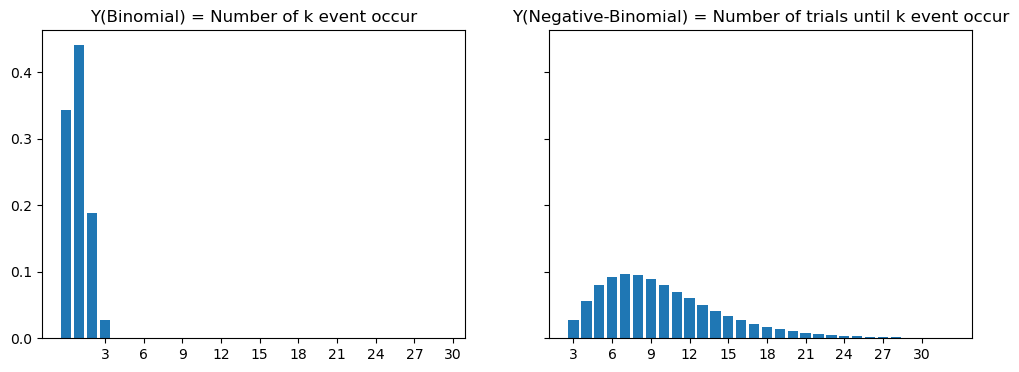

In [29]:
y = np.arange(0, 30)
k = 3
p = 0.3

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Binomial
ax[0].bar(y, st.binom.pmf(y, k, p))
ax[0].set_xticks(np.linspace(3, 30, num=10))
ax[0].set_title(f"Y(Binomial) = Number of k event occur")

# Negative-Binomial
ax[1].bar(y + k, st.nbinom.pmf(y, k, p))
ax[1].set_xticks(np.linspace(3, 30, num=10))
ax[1].set_title(f"Y(Negative-Binomial) = Number of trials until k event occur")

plt.show()

### 模型定义  

$$  
\begin{equation}  
\begin{array}{lcrl}  
\text{data:} & \hspace{.025in} & Y_i|\beta_0,\beta_1,\beta_2,r & \stackrel{ind}{\sim} \text{NegBin}\left(\mu_i, r \right) \;\; \text{ with } \;\; \mu_i= e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}}\\  
\text{priors:} & & \beta_{0}  & \sim N\left(0, 0.5^2\right) \\  
 & & \beta_1  & \sim N\left(0, 0.1^2\right) \\  
 & & \beta_2  & \sim N\left(0, 0.5^2\right) \\  
& & r & \sim \text{Exp}(1)\\  
\end{array}  
\end{equation}  
$$

In [30]:
with pm.Model(coords = {"obs_id": df.index}) as nb_model:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.1)           #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5)           #定义beta_2
    alpha = pm.Exponential("alpha", 1)

    stress = pm.MutableData("stress",df.stress, dims="obs_id")                           #自变量1:压力水平
    romantic = pm.MutableData("romantic",df.romantic, dims="obs_id")                     #自变量2:性别
    
    lam = pm.Deterministic("lam", 
                           pm.math.exp(beta_0 + beta_1*stress + beta_2*romantic), 
                           dims="obs_id")    #定义mu，自变量与先验结合
    
    likelihood = pm.NegativeBinomial("y_est", mu=lam, alpha=alpha, observed=df.networksize, dims="obs_id")


#### 绘制模型图

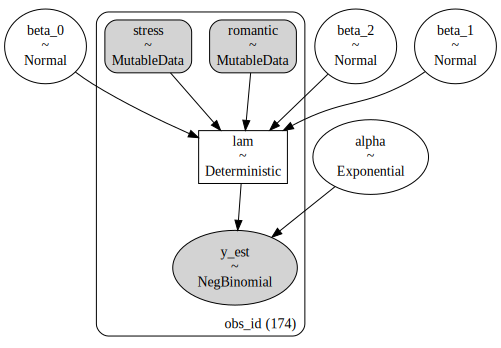

In [31]:
pm.model_to_graphviz(nb_model)

#### MCMC采样

In [32]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with nb_model:
    nb_model_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.


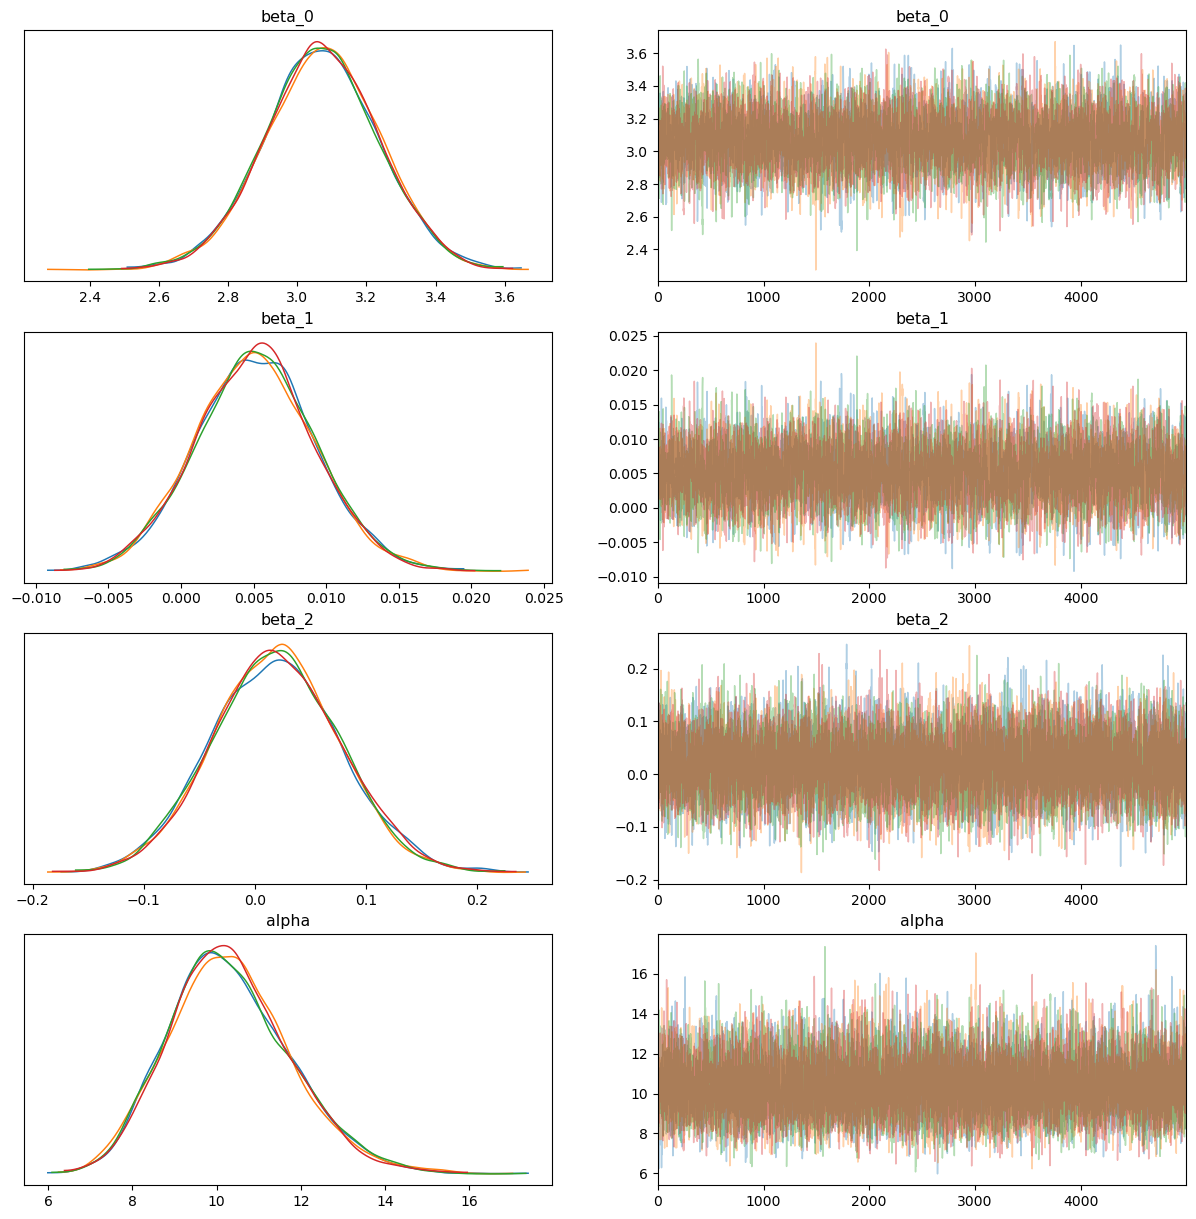

In [33]:
az.plot_trace(nb_model_trace, var_names=["beta_0","beta_1","beta_2","alpha"],
              figsize=(15,15),
              compact=False)
plt.show()

In [50]:
az.summary(nb_model_trace, var_names=["beta_0","beta_1","beta_2"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,3.070,0.167,2.764,3.391,0.002,0.002,6150.0,8169.0,1.0
beta_1,0.005,0.004,-0.003,0.013,0.000,0.000,6145.0,7775.0,1.0
beta_2,0.019,0.057,-0.092,0.124,0.000,0.000,13596.0,12443.0,1.0


### 后验参数解释  

以下的结果显示：  
- $\beta_0 = 3.1$，那么 $e^{\beta_0} = 22$， 表明在 X1 和 X2 为 0时，个体社交网络大小为 22。  
- $\beta_1 = 0.005$， $e^{\beta_0} = 1$， 表明压力数值每增加1点，社交网络大小增加 1；$\beta_2 = 0.018$， $e^{\beta_2} = 1$，表明恋爱后社交网络大小增加 1。  
- 然而，$\beta_1$ 和 $\beta_2$ 的94%HDI均包括0，说明压力分数和恋爱情况不能有效预测社交网络的大小。  


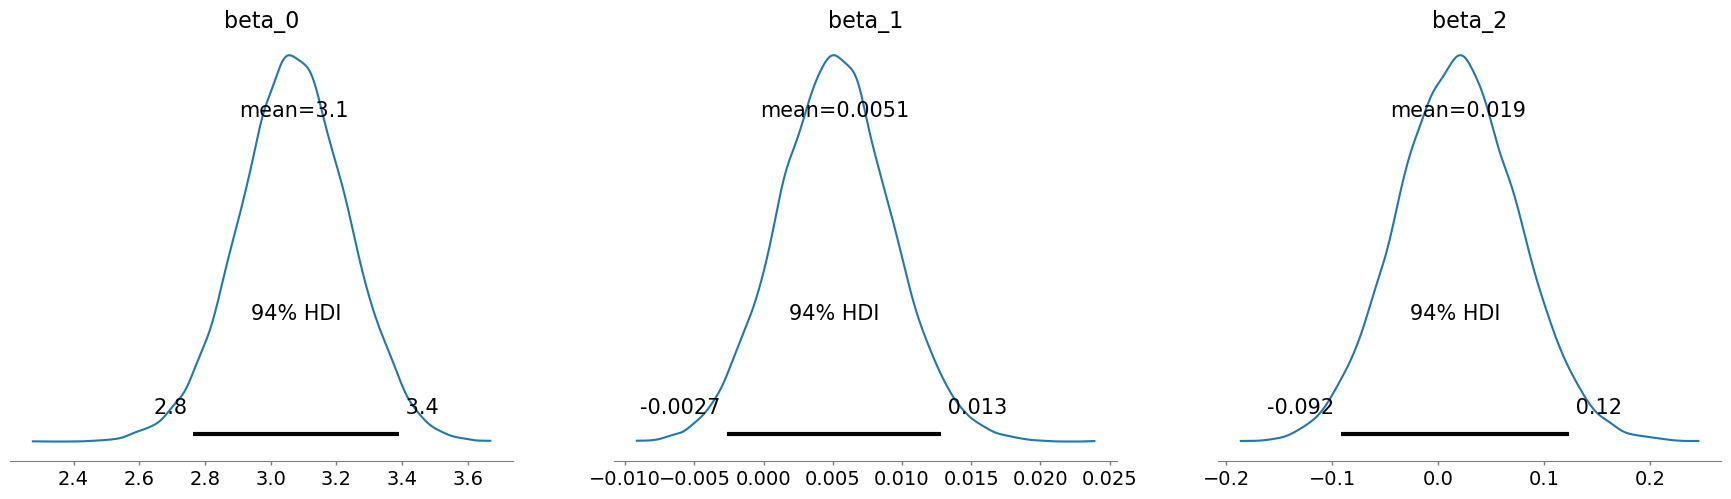

In [34]:
az.plot_posterior(nb_model_trace, var_names=["beta_0","beta_1","beta_2"])
plt.show()

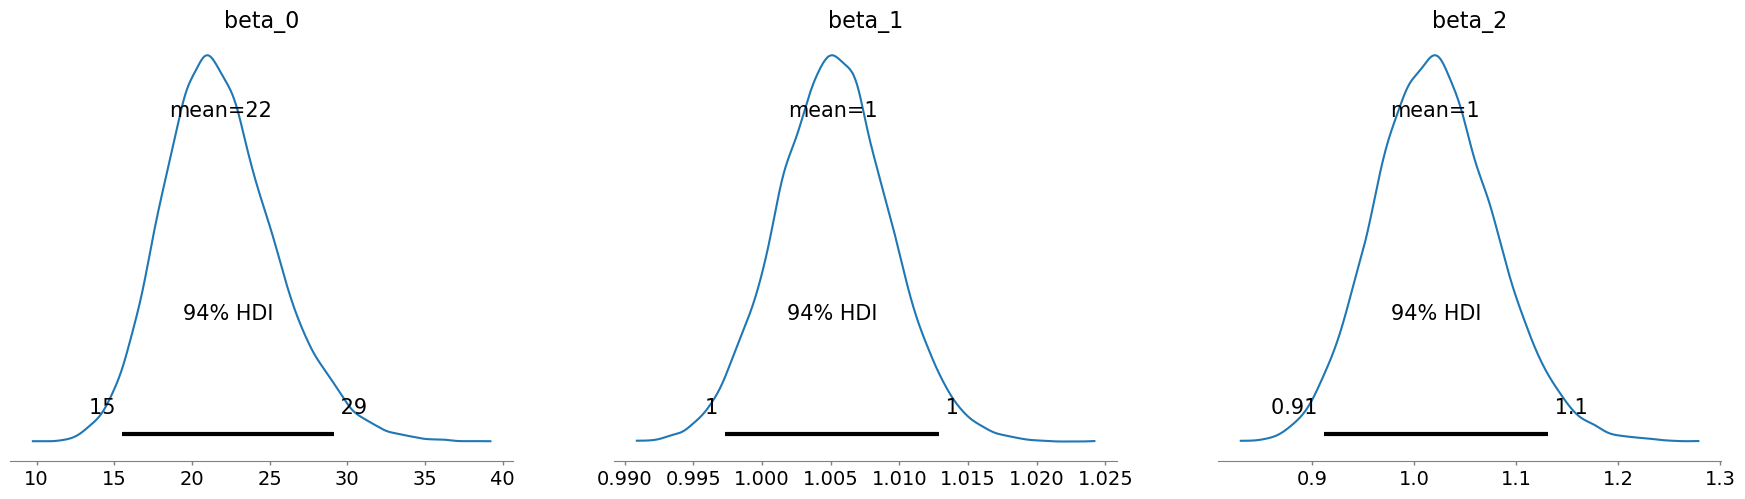

In [35]:
# 通过 np.exp 将 beta 参数进行转换
az.plot_posterior(nb_model_trace, var_names=["beta_0","beta_1","beta_2"], transform = np.exp)
plt.show()

#### 后验预测分布  

从可视化结果可以看出，负二项分布模型对于因变量的预测优于泊松分布。

Sampling: [y_est]


<Axes: xlabel='y_est / y_est'>

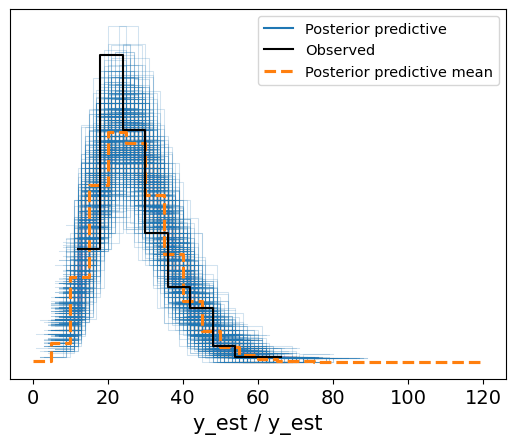

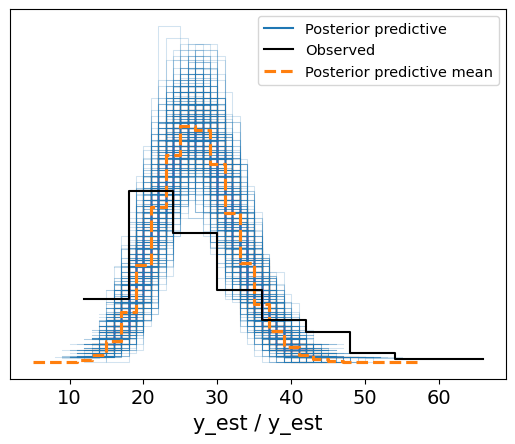

In [36]:
with nb_model:
    nb_model_ppc = pm.sample_posterior_predictive(nb_model_trace, random_seed=84735) 

az.plot_ppc(nb_model_ppc, num_pp_samples=500)
az.plot_ppc(poisson_model_ppc, num_pp_samples=500)

#### 评估后验预测

In [37]:
# 输出结果
nb_model_MAE = MAE(nb_model_ppc)
print(f"负二项回归模型MAE: {nb_model_MAE:.2f}")

# 输出结果
nb_model_outliers = counter_outlier(nb_model_ppc)
print(f"负二项回归模型超出95%hdi: {nb_model_outliers:.2f}")

负二项回归模型MAE: 6.48


负二项回归模型超出95%hdi: 9.00


### 模型比较  

* 从模型比较的结果也可以发现，负二项回归模型的 ELPD 最低，表明其结果最好。  
* 负二项和正态模型的差异为 9.24，但这个差异和两个模型的标准误接近，说明差异并不大。  
* MAE和后验预测区间的结果也显示：似乎正态模型的结果更优一点。

In [38]:
with nb_model:
    pm.compute_log_likelihood(nb_model_trace)

In [39]:
comparison_list = {
    "model1(normal)":normal_model_trace,
    "model2(poisson)":poisson_model_trace,
    "model3(negative binomial)":nb_model_trace,
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model3(negative binomial),0,-628.665376,3.224260,0.000000,0.874087,9.262558,0.000000,False,log
model1(normal),1,-637.875179,4.337762,9.209803,0.000000,11.968966,4.485639,False,log
model2(poisson),2,-709.111664,9.236234,80.446288,0.125913,30.371556,21.679144,False,log


In [52]:
summary_MAE_interval = pd.DataFrame({
    "model_name":["normal_model","possion_model","negative_binomial_model"],
    "MAE":[normal_model_MAE, poisson_model_MAE, nb_model_MAE],
    "HDI_num":[normal_model_MAE, poisson_model_outliers, nb_model_outliers]})

summary_MAE_interval

,model_name,MAE,HDI_num
0,normal_model,5.862387,5.862387
1,possion_model,5.914150,46.000000
2,negative_binomial_model,6.480775,9.000000


## 总结  

我们现在已经学习了正态、泊松和负二项分布数据结构的贝叶斯回归模型，然而还存在其他形式的回归模型，比如伽马、逆正态、对数正态等。所有这些选项都属于广义线性模型（**generalized linear model，GLM**）的一个大类。  
* 首先，必须注意因变量 Y 的结构。Y 是离散的还是连续的？是对称的还是倾斜的？Y 的取值范围是什么？这些问题可以帮助我们确定合适的数据结构。  
* 其次，定义数据的期望 E(Y ∣ ...)和链接函数 g(·)。  
	* 对于所有 GLM，E(Y ∣ ...) 对预测因子线性组合 (X1, X2, ..., Xp) 的依赖关系表示为 $g(E(Y \mid \ldots))=\beta_{0}+\beta_{1} X_{1}+\beta_{2} X_{2}+\cdots+\beta_{p} X_{p}$。其中链接函数 g(⋅) 取决于数据结构。  


| 模型     | 正态模型      | 泊松模型      | 负二项模型    |   
| -------- | ----------------- | ---------------- | ------------------ |  
| 数据模型 | $Y_i\| \beta_0, \beta_1, \cdots, \beta_p, \sigma \sim N(\mu_i, \sigma^2)$ | $Y_i\| \beta_0, \beta_1, \cdots, \beta_p \sim Pois(\lambda_i)$   |   $Y_i\| \beta_0, \beta_1, \cdots, \beta_p, \sigma \sim NegBin(\mu_i, r)$    |   
| 连接函数 | $g(\mu_i) = \mu_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \cdots + \beta_p X_{ip}$     | $g(\lambda_i) := \log(\lambda_i) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \cdots + \beta_p X_{ip}$ |  $g(\mu_i) := \log(\mu_i) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \cdots + \beta_p X_{ip}$  |   


我们不需要对每一种 GLM 进行非常仔细的研究。Bambi 工具提供了各种分布形构建帮助用户构建 GLM，以此适用于不同的数据分布。  

在后续的课程中，我们将开始使用 Bambi 来构建不同的贝叶斯模型。

#### 模型定义

In [77]:
# 我们需要对先验进行定义，在定义时需要注意参数的命名，可以先只传入表达式
# 查看在bambi中各参数对应的命名，接下来进行修改
import bambi as bmb

bambi_default = bmb.Model("networksize ~ stress + romantic", 
                     df,
                     family="negativebinomial")
bambi_default 

       Formula: networksize ~ stress + romantic
        Family: negativebinomial
          Link: mu = log
  Observations: 174
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 15.4284)
            stress ~ Normal(mu: 0.0, sigma: 0.3791)
            romantic ~ Normal(mu: 0.0, sigma: 5.168)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)

In [79]:
#定义先验并传入模型中
intercept_prior = bmb.Prior("Normal", mu=0, sigma=0.5)     #对应beta_0
stress_prior = bmb.Prior("Normal", mu=0, sigma=0.1)          #对应beta_1
romantic_prior = bmb.Prior("Normal", mu=0, sigma=0.5)
alpha_prior = bmb.Prior("Exponential", lam = 1)            #对应sigma

# 将三个参数的先验定义在字典prior中，注意参数的命名
priors = {"Intercept": intercept_prior, 
          "stress": stress_prior,
          "romantic": romantic_prior,
          "alpha": alpha_prior}

#定义关系式，传入数据
bambi_nb = bmb.Model("networksize ~ stress + romantic", 
                     df,
                     priors=priors, 
                     family="negativebinomial")

#总结对模型的设置
bambi_nb

       Formula: networksize ~ stress + romantic
        Family: negativebinomial
          Link: mu = log
  Observations: 174
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 0.5)
            stress ~ Normal(mu: 0.0, sigma: 0.1)
            romantic ~ Normal(mu: 0.0, sigma: 0.5)
        
        Auxiliary parameters
            alpha ~ Exponential(lam: 1.0)

In [69]:
bambi_nb_trace = bambi_nb.fit(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                              tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                              chains=4,
                              random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [networksize_alpha, Intercept, stress, romantic]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 68 seconds.


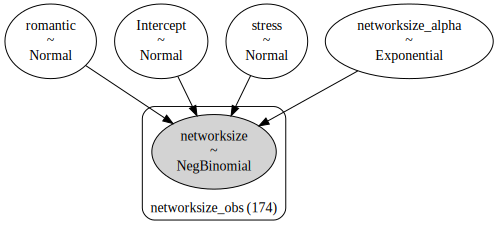

In [70]:
bambi_nb.graph()

### 后验参数解释

* 与pymc中的结果相比，在具体的数值大小存在差异，但关键结果并未发生改变
* 关键结果如：$\beta_1$ 和 $\beta_2$ 的94%HDI均包括0，说明压力分数和恋爱情况不能有效预测社交网络的大小

In [51]:
az.summary(bambi_nb_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.425,0.170,3.091,3.731,0.001,0.001,32473.0,15502.0,1.0
stress,-0.004,0.004,-0.011,0.004,0.000,0.000,32444.0,15500.0,1.0
romantic,-0.000,0.056,-0.107,0.100,0.000,0.000,31866.0,15996.0,1.0
networksize_alpha,10.643,1.472,7.825,13.307,0.008,0.006,31394.0,16641.0,1.0


### 后验预测分布

* 同样地，我们通过`bambi_nb.predict`生成后验预测分布并绘制，结果与pymc是相似的
* 在使用`bambi_nb.predict`后，后验预测分布的结果`posterior_predictive`会自动存入`bambi_nb_trace`中

In [73]:
bambi_nb.predict(bambi_nb_trace,kind="pps")

<Axes: xlabel='networksize / networksize'>

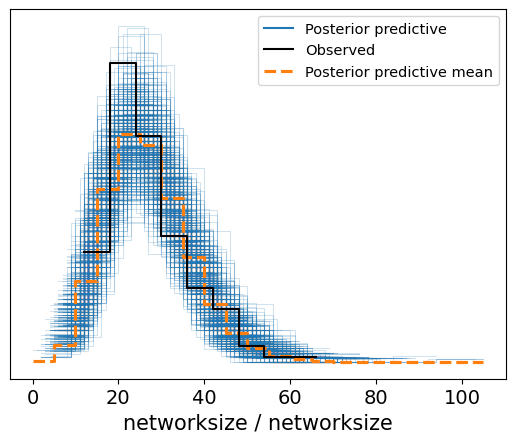

In [76]:
az.plot_ppc(bambi_nb_trace,num_pp_samples=500)

### 练习使用Bambi

* 我们使用bambi对负二项回归模型进行了定义与后验参数采样，在本节课中我们还介绍了正态回归模型和泊松回归模型，可以试着使用Bambi对上述模型进行定义

* 如：泊松回归模型
$$  
\begin{equation}  
\begin{array}{lcrl}  
\text{data:} & \hspace{.025in} & Y_i|\beta_0,\beta_1,\beta_2 & \stackrel{ind}{\sim} Pois\left(\lambda_i \right) \;\; \text{ with } \;\;  
\lambda_i = e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}}\\  
\text{priors:} & & \beta_{0} & \sim N\left(0, 0.5^2 \right) \\  
&& \beta_1 & \sim N(0, 0.1^2) \\  
&& \beta_2 & \sim N(0, 0.5^2) \\  
\end{array}  
\end{equation}  
$$

In [ ]:
import bambi as bmb

##---------------------------------------------------------------------------
#      提示：参照之前的代码与先验定义，对...中的内容进行修改
#---------------------------------------------------------------------------

#定义先验并传入模型中
intercept_prior = bmb.Prior(...)     #对应beta_0
stress_prior = bmb.Prior(...)          #对应beta_1
romantic_prior = bmb.Prior(...)
alpha_prior = bmb.Prior(...)            #对应sigma

# 将三个参数的先验定义在字典prior中
priors = {"Intercept": ..., 
          "stress": ...,
          "romantic": ...,
          "alpha": ...}

#定义关系式，传入数据
bambi_poisson = bmb.Model("...", 
                     data = df,
                     priors=..., 
                     family="...")

#总结对模型的设置
bambi_poisson

#### MCMC采样，后验参数估计

In [ ]:
bambi_poisson_trace = (...).fit(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                              tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                              chains=4,
                              random_seed=84735)

In [ ]:
az.summary(...)

#### 后验预测分布

In [ ]:
bambi_poisson.predict(...,kind="pps")
az.plot_ppc(...,num_pp_samples=500)

## 🎯加分练习：  

**回顾之前的研究问题**  

**问题0:  哪种分布可以更好的描述社交网络变量（本节课主要内容）**   

问题1：个体压力与社交网络大小的关系

问题2：恋爱情况与社交网络大小的关系  

**问题3：个体压力和恋爱情况与社交网络大小的关系（本节课主要内容）**

问题4：个体压力和恋爱情况对社交网络大小的交互作用  

**练习目标**  

在本节课中，我们知道负二项分布和正态分布可以更好地描述压力与恋爱情况对社交网络大小的影响。

在lec11中，我们逐一探究了吸烟、压力与二者地交互对自我控制水平的影响。在本节课中，我们只演示了问题3，并没有分别探究上述各预测变量与社交网络的关系，可以结合上节课的内容，使用pymc或bambi对剩下的问题进行模型定义与分析。

* Model 1: `"networksize ~ stress "`

* Model 2: `"networksize ~ romantic"`

* Model 3: `"networksize ~ stress + romantic"`(本节课内容)

* Model 4:`"networksize ~ stress + romantic + stress*romantic"`


![Image Name](https://cdn.kesci.com/upload/image/rkz1ehen1l.png?imageView2/0/w/960/h/960)